In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
from sklearn.impute import KNNImputer
import re

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold



# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score,auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report




import warnings #avoid warning flash
warnings.filterwarnings('ignore')

# Predicción de diabetes en los indios Pimas

El objetivo del dataset, es realizar la predicción de que pacientes padecen diabetes y cuales no, según los datos que nos encontramos en cada una de variables

-**Pregnancies**:  Número de embarazos

-**Glucose**: azcucar en sangre (mg/dl)

-**Blood Pressure**: Presion diastolica en sangre(mmHg)

-**Skin Thickness**:Grosor del pliegue cutaneo del triceps(mm)

-**Insulin**: Insulina sérica en sangre 2h (mu U/ml)

-**BMI**: Indice Masa Corporal (peso kg/ altura m2)

-**DiabetesPedrigreeFunction**: Historial genetico de diabetes

-**Age**:Edad

-**Outcome**: Variable objetivo (0 or 1) donde ‘0’ es no diabético y ‘1’ diabético.

#### Carga del dataset y analisis previo

In [2]:
df_diabetes = pd.read_csv('diabetes.csv',sep=',')

In [3]:
df_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df_diabetes.shape

(768, 9)

In [5]:
df_diabetes.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Con este pequeño analisis previo, podemos observar varias cosas. En primer lugar que todas las variables son númericas y nuestra variable objetivo es binaria. Tambien vemos que no tenemos ningun valor null/NA´s en ninguna de las variables.

Sin embargo, vemos que en algunas variables como Glucose, BloddPressure,SkinThickness, tenemos valores 0, los cuales podemos tratar como NA´s e imputarlos como ellos, ya que, nuestro conjunto de datos es "pequeño" y no podemos perder información


#### Tratamiento de valores 0 a valores NA´s

In [7]:
df_diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

#mostramos los valores nulls de cada variable
print(df_diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


Procedemos a sacar los histogramas para para ver como son las distribuciones y tratar los NA´s de la manera más adecuada

In [8]:
for j in df_diabetes.columns:
    print(j)
    print(df_diabetes[j].value_counts())

Pregnancies
1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64
Glucose
99.0     17
100.0    17
111.0    14
129.0    14
125.0    14
         ..
191.0     1
177.0     1
44.0      1
62.0      1
190.0     1
Name: Glucose, Length: 135, dtype: int64
BloodPressure
70.0     57
74.0     52
78.0     45
68.0     45
72.0     44
64.0     43
80.0     40
76.0     39
60.0     37
62.0     34
66.0     30
82.0     30
88.0     25
84.0     23
90.0     22
58.0     21
86.0     21
50.0     13
56.0     12
52.0     11
54.0     11
75.0      8
92.0      8
65.0      7
94.0      6
85.0      6
48.0      5
96.0      4
44.0      4
98.0      3
100.0     3
106.0     3
110.0     3
55.0      2
30.0      2
104.0     2
46.0      2
108.0     2
61.0      1
38.0      1
24.0      1
122.0     1
102.0     1
95.0      1
40.0      1
114.0     1
Name: BloodPressure, dtype: int64
SkinT

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

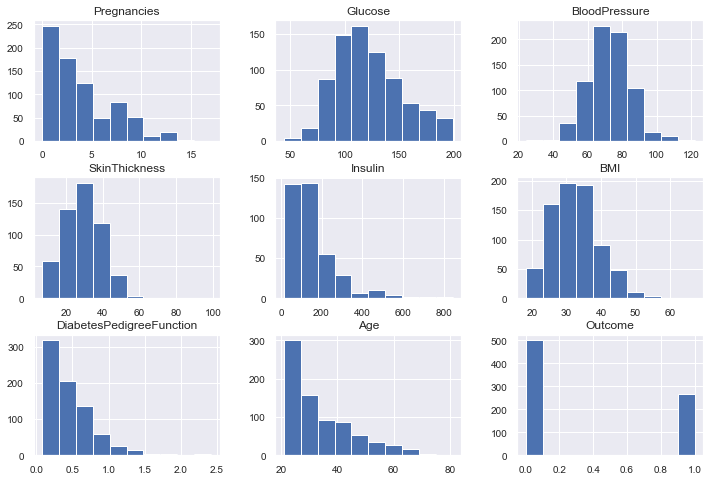

In [9]:
#sacamos los histogramas con los valores NA´s
df_diabetes.hist(figsize=(12,8))

Las variables que tienen la distribución sesgada a la izquierda (Ej:Insulin, Age,SkinThickness), tienen una distribucion negativa,y por el contrario las que tienen una distribucion con mayor número de datos a la derecha, tienen una distribución positiva. 

Para realizar la imputaciones, nos vamos a fijar en estas distribuciones.

#### Imputaciones de los valores NA´s

In [10]:
#utilizamos la funcion .fillna() para rellenar los NA´s de las variables con los valores indicados para cada una 

df_diabetes['Glucose'].fillna(df_diabetes['Glucose'].mean(), inplace = True)
df_diabetes['BloodPressure'].fillna(df_diabetes['BloodPressure'].mean(), inplace = True)
df_diabetes['BMI'].fillna(df_diabetes['BMI'].median(), inplace = True)
df_diabetes['SkinThickness'].fillna(df_diabetes['SkinThickness'].median(), inplace = True)
df_diabetes['Insulin'].fillna(df_diabetes['Insulin'].median(), inplace = True)

Para estas 2 primeras varibles,  los valores Na´s con la media, ya que las distribuciones son mas simetricas.  En los demás casos imputamos con la mediana acorde con sus distribuciones, para obtener el valor central.


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

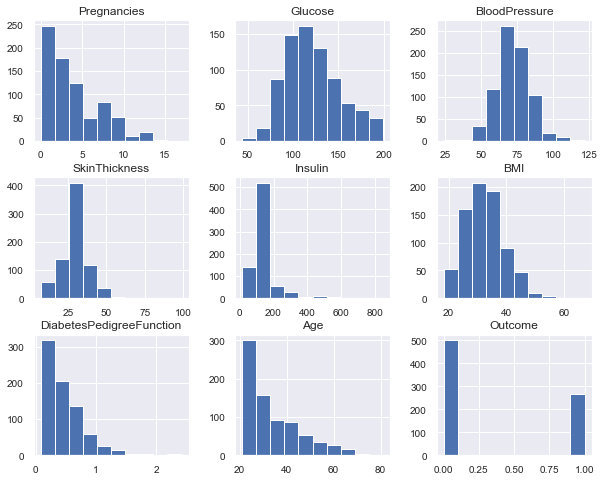

In [11]:
df_diabetes.hist(figsize=(10,8))

Realizamos una pequeña visualización de nutesra variable objetivo con el fin de conocer mejor los datos


número de diabéticos:  268
número de No diabéticos:  500


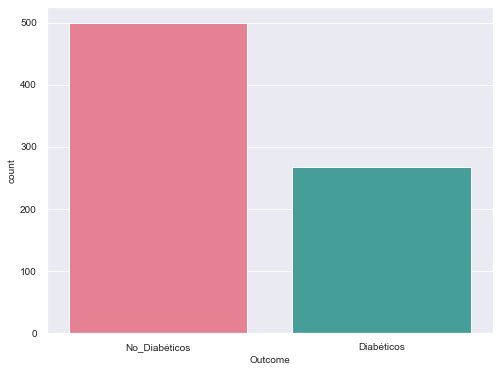

In [12]:
from matplotlib.pyplot import figure, show

figure(figsize=(8,6))
ax = sns.countplot(x=df_diabetes['Outcome'], data=df_diabetes,palette="husl")
ax.set_xticklabels(["No_Diabéticos","Diabéticos"])
No_Diabéticos, Diabéticos = df_diabetes['Outcome'].value_counts().values
print("número de diabéticos: ", Diabéticos)
print("número de No diabéticos: ", No_Diabéticos)

array([<AxesSubplot:ylabel='Outcome'>], dtype=object)

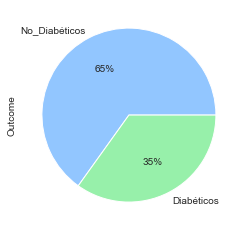

In [13]:
import matplotlib.style as style
style.available

style.use('seaborn-pastel')
labels = ["No_Diabéticos","Diabéticos"]
df_diabetes['Outcome'].value_counts().plot(kind='pie',labels=labels, subplots=True,autopct='%1.0f%%')

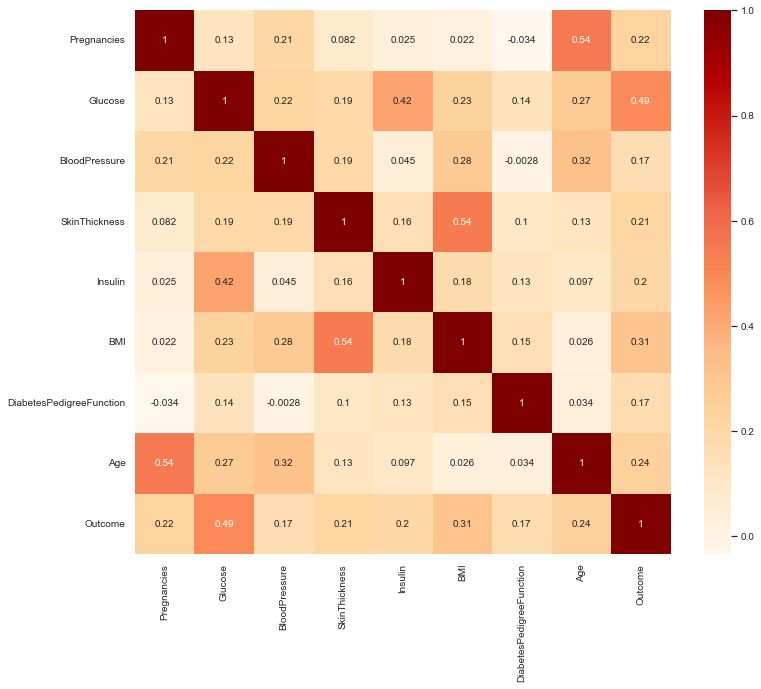

In [14]:

list_correlacion = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

plt.figure(figsize=(12,10))
df_correlacion = df_diabetes[list_correlacion]
correlation_mat = df_correlacion.corr()
#usamos la libreria heatmap, para sacar el mapa de calor
sns.heatmap(correlation_mat,annot=True,cmap='OrRd')
plt.show()


Sacamos el mapa de calor para ver como son las correlaciones entre las distintas variables, siendo 1 el maximo y 0 cuando no existe correlacion entre las variables. En nuestro caso, podemos observar, que tenemos variables que si tienen correlación, como es el caso de  la edad y los embarazos (0,54),  o la glucosa y la insulina (0,42). Tambien podemos destacar la reliacion entre BMI y Skin Thickness(0,54) ambas variables relacionadas con la grasa corporal

#### Detección de outliers

Pregnancies


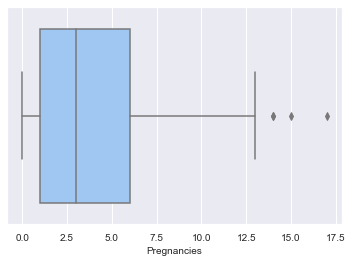

Glucose


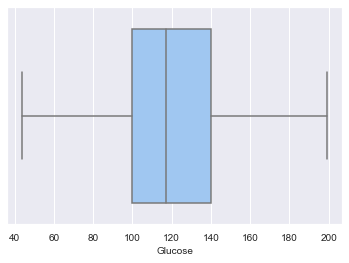

BloodPressure


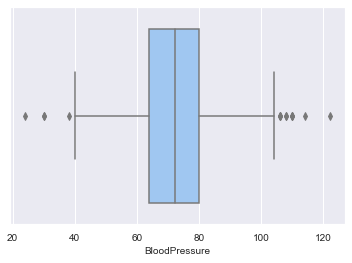

SkinThickness


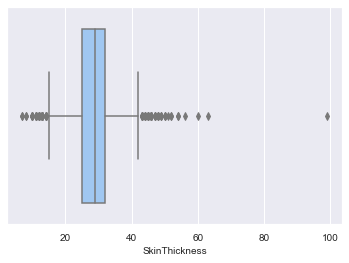

Insulin


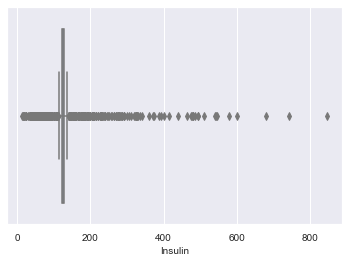

BMI


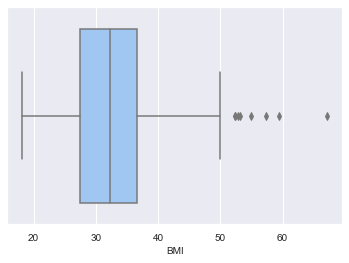

DiabetesPedigreeFunction


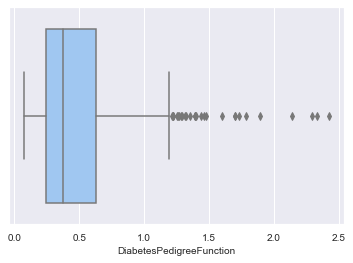

Age


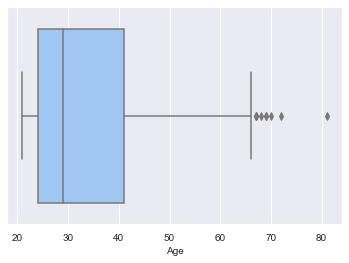

Outcome


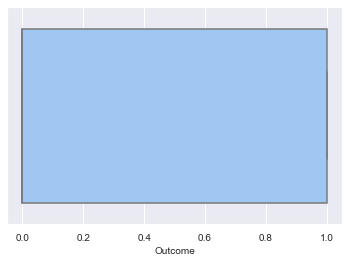

In [15]:
for i in list_correlacion:
    sns.boxplot(x=df_diabetes[i])
    print(i)
    plt.show()

Con estos diagramas de cajas podemos ver que variables tienen outliers y como se distribuyen dentro de cada y así analizar sus posibles tratatamientos

In [16]:
## creamos una funciona para la deteccion de outlier, teniendo en cuenta la funcion zscore
def z_score_outlier(df):
    out=[] 
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    print("Outliers:",out)

In [17]:
z_score_outlier(df_diabetes['DiabetesPedigreeFunction'])

Outliers: [2.288, 1.893, 1.781, 2.329, 1.476, 2.137, 1.731, 1.6, 2.42, 1.699, 1.698]


In [18]:
z_score_outlier(df_diabetes['Insulin'])

Outliers: [543.0, 846.0, 495.0, 485.0, 495.0, 478.0, 744.0, 680.0, 402.0, 545.0, 465.0, 415.0, 579.0, 474.0, 480.0, 600.0, 440.0, 540.0, 480.0, 510.0]


In [19]:
z_score_outlier(df_diabetes['BloodPressure'])

Outliers: [30.0, 110.0, 122.0, 30.0, 110.0, 110.0, 24.0, 114.0]


In [20]:
z_score_outlier(df_diabetes['BMI'])

Outliers: [53.2, 55.0, 67.1, 59.4, 57.3]


In [21]:
z_score_outlier(df_diabetes['Glucose'])

Outliers: []


#### Selección de variables y tratamiento de outliers

In [22]:
corr = abs(df_diabetes.corr())
corr[['Outcome']].sort_values(by = 'Outcome',ascending = False).style.background_gradient()

,Outcome
Outcome,1.000000
Glucose,0.492928
BMI,0.312038
Age,0.238356
Pregnancies,0.221898
SkinThickness,0.214873
Insulin,0.203790
DiabetesPedigreeFunction,0.173844
BloodPressure,0.166074


En la tabla anterior podemos ver la correlacion que tienen las variables con la variables objetivo. Vemos que las que menos correlación tienen, son las que mas outliers tenían. Por lo que, vamos a proceder a eliminar las variables 'insulin' , 'SkinThickness' y a seleccionar los datos  de 'DiabetesPedigreeFunction' que esten por debajo de 1.6, ya que los demás los vamos a considerar outliers.

In [23]:
## borramos del dataset la variable insuline debido a la gran cantidad de outliers que tiene
df_diabetes.drop(["Insulin"],axis=1, inplace=True)
df_diabetes.drop(["SkinThickness"],axis=1, inplace=True)

In [24]:
## seleccionamos  los datos que tienen menos de 1.6 en DiabetesPedigreeFunction, ya que los valores de sus outliers, pueden 'ensuciar' el resultado
df_diabetes2 = df_diabetes[df_diabetes['DiabetesPedigreeFunction'] < 1.6]


In [25]:
#separamos el dataset en 2, X con todos los datos menos la variable objetivo e Y los datos de la variable objetivo

#x= df_diabetes.drop("Outcome", axis=1)
#y = df_diabetes["Outcome"]


In [26]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x =  pd.DataFrame(sc_X.fit_transform(df_diabetes.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [27]:
x.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,1.549303,5.484909,-0.020496


In [28]:
y= df_diabetes['Outcome']


In [29]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

### Conjunto train test

In [30]:



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

clf=LabelEncoder()
df_diabetes2['Outcome']=clf.fit_transform(df_diabetes2['Outcome'])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 0,stratify = y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 6)
(154, 6)
(614,)
(154,)


#### Scaling

In [31]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)

### Construir un modelo analitico

Con la funcion Saca_metricas, sacamos de cada modelo las puntuaciones que nos van a hacer decirdir/ver que modelo es mejor. Nuestra variable es binaria, por lo que podemos sacar y analizar  la curva AUC  Los modelos a utilizar serán Regresión logística, DecisionTreeClassifier, RandomForest, LinearSVC, los cuales vamos a ir viendo y explicando uno a uno

In [32]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

#### Regresion logistica

matriz de confusión
[[89 11]
 [25 29]]
accuracy
0.7662337662337663
precision
0.725
recall
0.5370370370370371
f1
0.6170212765957447
AUC
0.7135185185185186


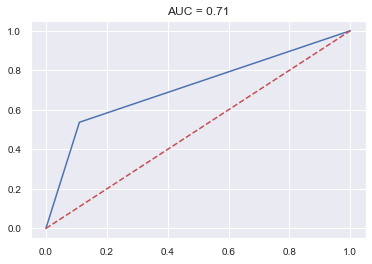

In [33]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred        = classifier.predict(x_test)
saca_metricas(y_test, y_pred)

#### RandomForest

matriz de confusión
[[87 13]
 [21 33]]
accuracy
0.7792207792207793
precision
0.717391304347826
recall
0.6111111111111112
f1
0.6599999999999999
AUC
0.7405555555555555


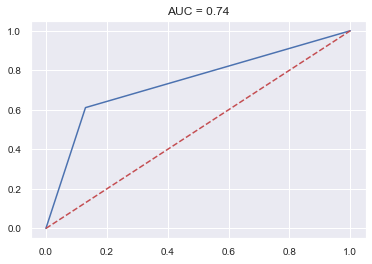

In [34]:
rf_classifier = RandomForestClassifier().fit(x_train, y_train)
y_pred        = rf_classifier.predict(x_test)
saca_metricas(y_test, y_pred)

In [35]:
results = cross_val_score(estimator=rf_classifier, X=x_train, y=y_train, cv=5)

results

array([0.76422764, 0.75609756, 0.72357724, 0.76422764, 0.73770492])

#### SVM

matriz de confusión
[[88 12]
 [23 31]]
accuracy
0.7727272727272727
precision
0.7209302325581395
recall
0.5740740740740741
f1
0.6391752577319588
AUC
0.7270370370370369


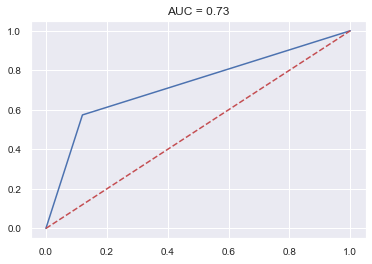

In [36]:
svm_classifier = SVC().fit(x_train, y_train)
y_pred         = svm_classifier.predict(x_test)

saca_metricas(y_test, y_pred)

#### Naive Bayes

matriz de confusión
[[88 12]
 [22 32]]
accuracy
0.7792207792207793
precision
0.7272727272727273
recall
0.5925925925925926
f1
0.6530612244897959
AUC
0.7362962962962963


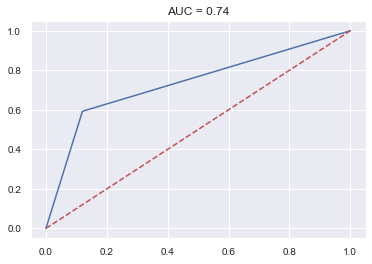

In [37]:
from sklearn import naive_bayes
nb_classifier = naive_bayes.GaussianNB(var_smoothing=0.001).fit(x_train, y_train)
y_pred        = nb_classifier.predict(x_test)

saca_metricas(y_test, y_pred)

#### KNN

matriz de confusión
[[86 14]
 [24 30]]
accuracy
0.7532467532467533
precision
0.6818181818181818
recall
0.5555555555555556
f1
0.6122448979591836
AUC
0.7077777777777777


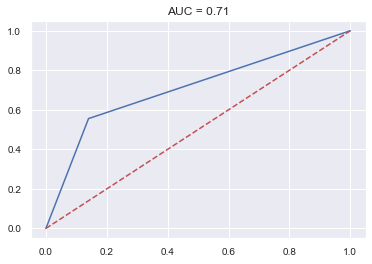

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(x_train, y_train)
y_pred        = knn.predict(x_test)

saca_metricas(y_test, y_pred)

Como vemos nuestro mejor modelo es **RandomForest**, el cual tiene una **accuracy del 0.84 y AUC del 0.8**. Además si nos fijamos en los demás parametros, vemos que tambien están ligeramente por encima de los otros metodos.

#### Mejora del modelo

Vamos a crear un grid con los parametros que puede recorrer para intentar mejorar estos resultados

In [39]:
grid_param = {
    'n_estimators': [100,300,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [16,20,22,24],
    'max_features': ['auto', 'sqrt'],

}

In [40]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

In [41]:
model_grid = GridSearchCV(estimator=rf_classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=stratified_kfold,
                     n_jobs=-1)

model_grid.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 20, 22, 24],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [42]:
print(model_grid.best_params_)
print(model_grid.best_score_)


{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 300}
0.8245542635658915


In [43]:
 ihbbk

NameError: name 'ihbbk' is not defined

Una vez obtenidos los mejores parametros, procedemos a entrenar el modelo con ellos y que ver que sucede

matriz de confusión
[[89 11]
 [20 34]]
accuracy
0.7987012987012987
precision
0.7555555555555555
recall
0.6296296296296297
f1
0.6868686868686867
AUC
0.7598148148148149


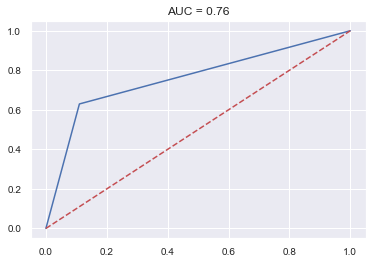

In [44]:
rf_classifier2 = RandomForestClassifier(criterion= 'entropy', max_depth= 20, max_features= 'auto', n_estimators= 300).fit(x_train, y_train)
y_pred        = rf_classifier2.predict(x_test)
saca_metricas(y_test, y_pred)

Vemos que el modelo  nos da unos resultados similares, pero mejora los valores de la validacion cruzada. Para ver si el modelo tiene overfitting, realizamos la validacion cruzada. A continuación podemos ver que los resultados  son correctos y mejoran a la anterior, ya que no superan la diferente de 0,3 o 0,4 entre ellos

In [45]:
results2 = cross_val_score(estimator=rf_classifier2, X=x_train, y=y_train, cv=5)

results2

array([0.71544715, 0.75609756, 0.75609756, 0.80487805, 0.7295082 ])

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Predicción

In [ ]:
modelo_proba = rf_classifier2.predict_proba(x)[:,1]
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=x.index))
#modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [ ]:
modelo_proba

In [ ]:

df_diabetes2.loc[300]

In [ ]:
df_diabetes2.loc[680]

In [ ]:
Outcome= y 

modelo_proba['Outcome']= Outcome

In [ ]:
modelo_proba